In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn.functional as f 
from torch.autograd import Variable
torch.backends.cudnn.deterministic = True
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt


from scipy import stats

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [3]:
number = 1
fileTrain = '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Train_rrlyr-'+str(number)+'.csv'
fileTest = '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Test_rrlyr-'+str(number)+'.csv'
train_dataset = pd.read_csv(fileTrain, index_col ='Unnamed: 0')
test_dataset = pd.read_csv(fileTest)

In [4]:
try:
    train_dataset =  train_dataset.drop(['Pred', 'Pred2', 'h', 'e', 'u','ID'], axis = 1)
    for col in train_dataset.columns:
        if col not in ['label']:
            if train_dataset[col].var()==0:
                print(col)
                del train_dataset[col]
    test_dataset = test_dataset[list(train_dataset.columns)]
except:
    print(col)
    print('---')

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0


In [5]:
n = train_dataset.shape[0] 
epsilon = 0
input_size = train_dataset.shape[1]-1
hidden_size = 1000
hidden_size2 = 1000
num_classes = 2
num_epochs = 5
batch_size = 64
learning_rate = 0.001
regularization = False
add_DR_based_data = True


In [6]:
#minimum_period = train_dataset['PeriodLS'].min()
#maximum_period = 5#train_dataset['PeriodLS'].max()
train_dataset = train_dataset.sample(n)
#label = train_dataset['label']
#del train_dataset['label']
#scaler = StandardScaler()
# train_dataset_scaled = scaler.fit_transform(train_dataset)
#train_dataset = pd.DataFrame(train_dataset_scaled, columns=train_dataset.columns)
#train_dataset['label'] = label
train_dataset.head()


,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,FluxPercentileRatioMid20,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,label
95995,0.0285,0.000388,8,0.313333,19.633469,0.943106,0.705834,0.016779,26.795616,0.142857,...,0.370698,4.82976,0.092830,0.014638,0.797654,0.705975,1.786092,2.438108,1.456502,ClassB
117508,0.0315,0.516421,2,0.316667,60.864553,0.368127,0.217651,0.010067,27.877249,0.150943,...,-0.042560,4.09580,0.016120,0.015469,0.800189,0.742621,1.611617,2.034464,1.326873,ClassB
202103,0.5265,0.000000,1,0.167785,38.969618,0.667236,0.484111,0.000000,1137.612586,0.053706,...,1.986051,0.08391,3.457299,0.267731,0.731573,0.529509,1.680231,2.234334,1.621988,ClassB
149789,0.0630,0.000055,1,0.472222,12.175217,0.052550,1.184228,0.000000,4.512393,0.209677,...,0.284275,1.81470,-1.265863,0.041730,0.874448,0.886609,1.537870,1.855204,1.268149,ClassB
270586,0.0185,0.137914,2,0.320000,127.155853,0.247697,0.120381,0.000000,83.450472,0.166667,...,0.034766,7.68972,-0.139093,0.009458,0.812045,0.782909,1.758050,2.459552,1.458589,ClassB


In [7]:
# Losslabel = test_dataset[['label']]
#del test_dataset['label']
#test_dataset_scaled = scaler.transform(test_dataset)
#test_dataset = pd.DataFrame(test_dataset_scaled, columns=test_dataset.columns)
#test_dataset['label'] = label
#test_dataset.head()

In [8]:
#(np.random.uniform(0.1,1.1)-minimum_period)/(maximum_period-minimum_period)

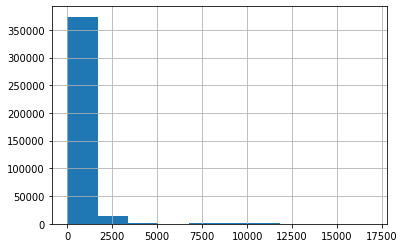

In [9]:
train_dataset['PeriodLS'].hist()
plt.show()

In [10]:
samples = 500
number_columns = train_dataset.shape[1]
if add_DR_based_data:
    for i in range(0):
        new_data = pd.DataFrame(train_dataset.sample(1000).mean()).T
        new_data['PeriodLS']= (np.random.uniform(0.2-epsilon,1.0+epsilon))#-minimum_period)/(maximum_period-minimum_period)
        new_data['label'] = 'ClassA'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
    
    for i in range(0):
        new_data = pd.DataFrame(train_dataset.sample(1000).mean()).T
        new_data['PeriodLS']=(np.random.uniform(0.0,0.2))#-minimum_period)/(maximum_period-minimum_period)
        new_data['label'] = 'ClassB'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        
    for i in range(0):    
        new_data = pd.DataFrame(train_dataset.sample(1000).mean()).T
        new_data['PeriodLS']=(np.random.uniform(1.0,1.2))#-minimum_period)/(maximum_period-minimum_period)
        new_data['label'] = 'ClassB'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        
    for i in range(0):    
        new_data = pd.DataFrame([train_dataset.sample(1000).mean()]).T
        new_data['PeriodLS']= 1.0#-minimum_period)/(maximum_period-minimum_period)
        new_data['label'] = 'Noise'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        
    for i in range(0):    
        new_data = pd.DataFrame([0 for i in range(number_columns)]).T
        #print(new_data.shape)
        new_data.columns = train_dataset.columns
        new_data['PeriodLS']= 1.0#-minimum_period)/(maximum_period-minimum_period)
        new_data['label'] = 'Noise'
        #print(new_data.shape)
        #print(train_dataset.shape)
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames, sort=True, axis=0)
        #print(train_dataset.shape)
        
    for i in range(0):    
        new_data = pd.DataFrame([0 for i in range(number_columns)]).T
        #print(new_data.shape)
        new_data.columns = train_dataset.columns
        new_data['PeriodLS']= 0.2#-minimum_period)/(maximum_period-minimum_period)
        new_data['label'] = 'Noise'
        #print(new_data.shape)
        #print(train_dataset.shape)
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames, sort=True, axis=0)
        #print(train_dataset.shape)

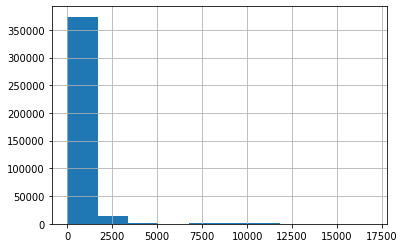

In [11]:
train_dataset['PeriodLS'].hist()
plt.show()

In [12]:
label = train_dataset['label']
del train_dataset['label']
train_dataset=(train_dataset-train_dataset.mean())/train_dataset.std()
z_scores = stats.zscore(train_dataset)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
train_dataset['label'] = label
train_dataset = train_dataset[filtered_entries]

In [13]:
label = test_dataset['label']
del test_dataset['label']
test_dataset=(test_dataset-test_dataset.mean())/test_dataset.std()
z_scores = stats.zscore(test_dataset)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
test_dataset['label'] = label
test_dataset = test_dataset[filtered_entries]

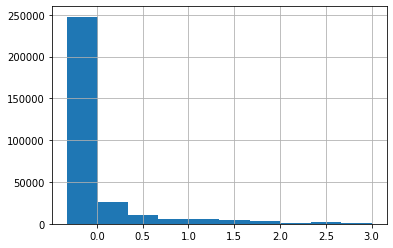

In [14]:
train_dataset['PeriodLS'].hist()
plt.show()

In [15]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

Cases using DR 1: Period $ \in [0.2,1.0]$ days

In [16]:
train_dataset['label'] = train_dataset['label'].str.replace('ClassA', '1')
train_dataset['label'] = train_dataset['label'].str.replace('ClassB', '0')
train_dataset['label'] = train_dataset['label'].str.replace('Noise', '0.5')
#train_dataset['label'] = train_dataset['label'].astype(float) 
train_target = torch.tensor(train_dataset['label'].values.astype(np.float32))
train = torch.tensor(train_dataset.drop('label', axis = 1).values.astype(np.float32)) 
#train = f.normalize(train)
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size)

In [17]:
val_dataset['label'] = val_dataset['label'].str.replace('ClassA', '1')
val_dataset['label'] = val_dataset['label'].str.replace('ClassB', '0')
val_dataset['label'] = val_dataset['label'].str.replace('Noise', '0.5')
#val_dataset['label'] = val_dataset['label'].astype(float) 
val_target = torch.tensor(val_dataset['label'].values.astype(np.float32))
val = torch.tensor(val_dataset.drop('label', axis = 1).values.astype(np.float32)) 
#val = f.normalize(val)
val_tensor = data_utils.TensorDataset(val, val_target) 
val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = batch_size)

In [18]:
test_dataset['label'] = test_dataset['label'].str.replace('ClassA', '1')
test_dataset['label'] = test_dataset['label'].str.replace('ClassB', '0')

test_target = torch.tensor(test_dataset['label'].values.astype(np.float32))
test = torch.tensor(test_dataset.drop('label', axis = 1).values.astype(np.float32)) 
#test = f.normalize(test)
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size)

In [19]:
test_target

tensor([0., 1., 0.,  ..., 1., 1., 1.])

In [20]:

class Net(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size2, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        #self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.1)
        self.fc2 = nn.Linear(hidden_size, hidden_size2)  
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes) 
        #self.sigmoid = nn.Sigmoid()
        #self.dropout = nn.Dropout(p=0.1)
        #self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        #self.batchnorm2 = nn.BatchNorm1d(hidden_size)
        
        
    def forward(self, x):
        out = self.fc1(x)
        #out = self.batchnorm1(out)
        #out = self.relu(out)
        out = self.leakyrelu(out)
        out = self.fc2(out)
        #out = self.batchnorm1(out)
        out = self.relu2(out)
        out = self.fc3(out)
        #x = self.dropout(x)
        #out = self.sigmoid(out)
        return out
    
net = Net(input_size, hidden_size, hidden_size2, num_classes)
net.cuda()   

Net(
  (fc1): Linear(in_features=60, out_features=1000, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1000, out_features=2, bias=True)
)

In [21]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  

#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  

In [22]:
# Train the Model   
hist_train = []
hist_val = []

for epoch in range(num_epochs):
    print('-----------Training----------------------------')
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (star, labels) in enumerate(train_loader):  
        star = Variable(star.view(-1, input_size)).cuda()
        labels = Variable(labels).cuda()
        #print(star[:,49])
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(star)
        #print(softmax(outputs))
        #m = nn.Sigmoid()
        
        loss = criterion(outputs, labels.long())
        
        if regularization:
            l1_regularization = 0
            l2_regularization = 0
            lambda1 = 0.001
            lambda2 = 0.001
            for param in net.parameters():
                l1_regularization += torch.norm(param, 1)**2
                l2_regularization += torch.norm(param, 2)**2
            loss = loss + lambda1*l1_regularization + lambda2*l2_regularization
                
        loss.backward()
        optimizer.step()
        
        epoch_loss += outputs.shape[0] * loss.item()      
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0
        
    hist_train.append(epoch_loss)
    print(epoch+1, epoch_loss / len(train_loader))
    print('-----------Validation----------------------------')
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (star, labels) in enumerate(val_loader):  
        star = Variable(star.view(-1, input_size)).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(star)
        loss = criterion(outputs, labels.long())    
        epoch_loss += outputs.shape[0] * loss.item()      
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0
    print(epoch+1, epoch_loss / len(val_loader))
    hist_val.append(epoch_loss)


-----------Training----------------------------
[1,  2000] loss: 0.000
[1,  4000] loss: 0.000
1 1.0967837209674085
-----------Validation----------------------------
1 0.7222699827766822
-----------Training----------------------------
[2,  2000] loss: 0.000
[2,  4000] loss: 0.000
2 0.8138644383121649
-----------Validation----------------------------
2 0.6542888644481233
-----------Training----------------------------
[3,  2000] loss: 0.000
[3,  4000] loss: 0.000
3 0.7121411018056292
-----------Validation----------------------------
3 0.6390394378443792
-----------Training----------------------------
[4,  2000] loss: 0.000
[4,  4000] loss: 0.000
4 0.6751730316241951
-----------Validation----------------------------
4 0.6427349112302181
-----------Training----------------------------
[5,  2000] loss: 0.000
[5,  4000] loss: 0.000
5 0.61290439201793
-----------Validation----------------------------
5 0.5721522390845469


In [23]:
# Test the Model
correct = 0
total = 0
for star, labels in test_loader:
    images = Variable(star.view(-1, input_size)).cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.long()).sum()
print('Accuracy of the network on test objects: %d %%' % (100 * correct / total))
acc_testing = 100 *correct / total
print(np.asarray(acc_testing))

Accuracy of the network on test objects: 55 %
55


In [24]:
correct = 0
total = 0
for star, labels in train_loader:
    images = Variable(star.view(-1, input_size)).cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.long()).sum()
print('Accuracy of the network on train objects: %d %%' % (100 * correct / total))
acc_training = 100 *correct / total

Accuracy of the network on train objects: 99 %


In [25]:
# Save the Model
torch.save(net.state_dict(), 'model.pkl')

In [26]:
def softmax(x): 
    return x.exp() / (x.exp().sum(-1)).unsqueeze(-1)

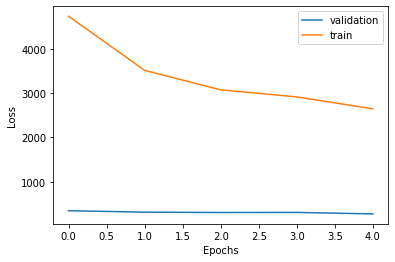

In [27]:
plt.plot(hist_val, label ='validation')
plt.plot(hist_train, label ='train')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('images/'+str(samples)+'_'+str(epsilon)+'_'+str(n)+"_"+str(hidden_size)+"_Loss_Training.png")
plt.show()

In [28]:
csv_file = open("size_MLP_noise.csv", "a")
csv_file.write(str(np.asarray(acc_testing))+","+str(np.asarray(acc_training))+","+str(samples)+","+str(epsilon)+","+str(n)+","+str(hidden_size)+"\n")
csv_file.close()